# Groundwater transport modeling



In [1]:
import nlmod
import numpy as np
import xarray as xr

nlmod.show_versions()

Python version: 3.9.7
NumPy version: 1.21.2
Xarray version: 2022.10.0
Matplotlib version: 3.7.0

nlmod version: 0.5.2b


In [2]:
nlmod.util.get_color_logger('INFO');

In [3]:
# model settings
model_ws = "ijmuiden"
model_name = "IJmuiden"

figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

extent = [95000.0, 105000.0, 494000.0, 500000.0]
delr = 100.0
delc = 100.0
steady_state = True
start_time = "2015-1-1"
add_northsea = True
starting_head = 1.0

In [4]:
layer_model = nlmod.read.regis.get_combined_layer_models(
    extent,
    use_regis=True,
    regis_botm_layer="MSz1",
    use_geotop=True,
    cachedir=cachedir,
    cachename="combined_layer_ds.nc",
)

# create a model ds by changing grid of layer_model
ds = nlmod.to_model_ds(
    layer_model, model_name, model_ws, delr=delr, delc=delc, transport=1
)

# add time discretisation
ds = nlmod.time.set_ds_time(
    ds, start_time=start_time, steady_state=steady_state, perlen=365 * 5
)

if add_northsea:
    ds = nlmod.read.rws.add_northsea(ds, cachedir=cachedir)

INFO:nlmod.cache:using cached data -> combined_layer_ds.nc
INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.read.rws:nan values at the northsea are filled using the bathymetry from jarkus
INFO:nlmod.cache:using cached data -> sea_ds.nc
INFO:nlmod.cache:using cached data -> bathymetry_ds.nc


In [5]:
cl = xr.open_dataset("../../../pwn_diep/data/3dchloride_result.nc")

# interpolate to modelgrid
cli = cl.sel(percentile="p50").interp(x=ds.x, y=ds.y, method="nearest")

cli

<xarray.Dataset>
Dimensions:      (layer: 46, y: 60, x: 100)
Coordinates:
    percentile   <U3 'p50'
  * layer        (layer) int32 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46
    z            (layer) float64 110.0 80.0 50.0 40.0 ... -280.0 -300.0 -500.0
    dz           (layer) float64 30.0 30.0 20.0 10.0 ... 20.0 20.0 110.0 200.0
    top          (layer) float64 125.0 95.0 65.0 45.0 ... -270.0 -290.0 -400.0
    bottom       (layer) float64 95.0 65.0 45.0 35.0 ... -290.0 -400.0 -600.0
    dy           float64 -250.0
    dx           float64 250.0
  * x            (x) float64 9.505e+04 9.515e+04 ... 1.048e+05 1.05e+05
  * y            (y) float64 5e+05 4.998e+05 4.998e+05 ... 4.942e+05 4.94e+05
Data variables:
    3d-chloride  (layer, y, x) float64 nan nan nan ... 1.568e+04 1.568e+04

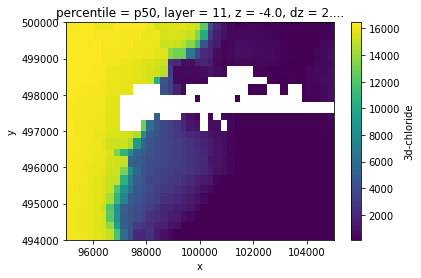

In [6]:
cli.isel(layer=10)["3d-chloride"].plot();

In [7]:
if "layer" in ds["top"].dims:
    # make sure there is no layer dimension in top
    ds["top"] = ds["top"].max(dim="layer")

cl_ar = []

for ilay in range(len(ds.layer)):
    if ilay == 0:
        top = ds["top"]
    else:
        top = ds["botm"][ilay - 1].drop_vars("layer")
    bot = ds["botm"][ilay].drop_vars("layer")

    cl_top = cli.top
    cl_bot = cli.bottom
    cl_top = cl_top.where(cl_top < top, top)
    cl_top = cl_top.where(cl_top > bot, bot)
    cl_bot = cl_bot.where(cl_bot < top, top)
    cl_bot = cl_bot.where(cl_bot > bot, bot)
    cl_thk = cl_top - cl_bot

    cl_ar.append(xr.where(cl_thk > 0, cli["3d-chloride"], np.nan).mean(dim="layer"))
    
ds["chloride"] = xr.concat(cl_ar, ds.layer)

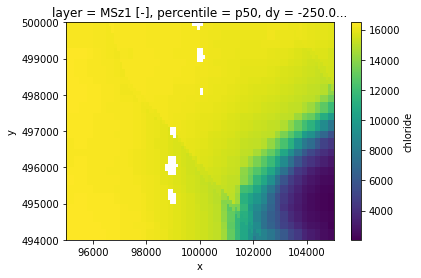

In [8]:
ds["chloride"].isel(layer=39).plot();

In [9]:
ds['chloride'] = ds['chloride'].fillna(0.0)

In [10]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim, complexity="MODERATE")

# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)


INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:creating modflow OC


In [11]:
# voeg grote oppervlaktewaterlichamen toe o.b.v. shapefile
da_name = "rws_oppwater"
rws_ds = nlmod.read.rws.get_surface_water(
    ds, da_name, cachedir=ds.cachedir, cachename=da_name
)
# add data to model dataset
ds.update(rws_ds)

# build ghb package
ghb = nlmod.gwf.ghb(ds, gwf, da_name, auxiliary="chloride")


INFO:nlmod.cache:using cached data -> rws_oppwater.nc
INFO:nlmod.gwf.gwf:creating modflow GHB


In [12]:
# surface level drain
# ahn_ds = nlmod.read.ahn.get_ahn(ds, cachedir=ds.cachedir, cachename="ahn")
# # add data to model dataset
# ds.update(ahn_ds)

# # build surface level drain package
# drn = nlmod.gwf.surface_drain_from_ds(ds, gwf, resistance=10.0)

In [13]:
# add constant head cells at model boundaries
ds.update(nlmod.grid.mask_model_edge(ds, ds["idomain"]))
chd = nlmod.gwf.chd(ds, gwf, chd="edge_mask", head="starting_head", auxiliary="chloride")


INFO:nlmod.gwf.gwf:creating modflow CHD


In [14]:
# download knmi recharge data
# knmi_ds = nlmod.read.knmi.get_recharge(
#     ds, cachedir=ds.cachedir, cachename="recharge"
# )
# # update model dataset
# ds.update(knmi_ds)

# create recharge package
# rch = nlmod.gwf.rch(ds, gwf)


In [15]:
ds.attrs['drhodc'] = (1025 - 1000) / (18_000. - 0.0)
ds.attrs['denseref'] = 1000.0
ds.attrs['crhoref'] = 0.0
ds.attrs['porosity'] = 0.3

In [16]:
buy = nlmod.gwf.buy(ds, gwf)

In [17]:
buy.packagedata

{internal}
(rec.array([(0, 0.00138889, 0., 'gwt_IJmuiden', 'none')],
          dtype=[('irhospec', '<i8'), ('drhodc', '<f8'), ('crhoref', '<f8'), ('modelname', 'O'), ('auxspeciesname', 'O')]))

In [18]:
gwt = nlmod.gwt.gwt(ds, sim)

dis_gwt = nlmod.gwt.dis(ds, gwt)

adv = nlmod.gwt.adv(ds, gwt)

dsp = nlmod.gwt.dsp(ds, gwt)

mst = nlmod.gwt.mst(ds, gwt)

ic_gwt = nlmod.gwt.ic(ds, gwt, "chloride")

oc_gwt = nlmod.gwt.oc(ds, gwt)

ssm = nlmod.gwt.ssm(ds, gwt, pkg_sources=["GHB", "CHD"])

gwfgwt = nlmod.gwt.gwfgwt(ds, sim)

INFO:nlmod.gwt.gwt:creating modflow GWT
INFO:nlmod.gwt.gwt:creating modflow DIS
INFO:nlmod.gwt.gwt:creating modflow MST
INFO:nlmod.gwt.gwt:creating modflow IC
INFO:nlmod.gwt.gwt:creating modflow OC
INFO:nlmod.gwt.gwt:creating modflow SSM


In [19]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing package IJmuiden.gwfgwt...
  writing model IJmuiden...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb...
    writing package chd...
    writing package buy...
  writing model gwt_IJmuiden...
    writing model name file...
    writing package dis...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ic...
    writing package oc...
    writing package ssm...
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: ../../../nlmod/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
               